# GEOLOCATION OF USERS

#### Steps to geoloc users

1. From **user id**, get its full profile (that includes the `location` field)
2. From the `location` string of the full profile, get the **geographical coordinate** using Photon API.

## Packages import

In [25]:
from datetime import date
import os
from os.path import join

import contextily as ctx
import datatable as dt
from datatable import f
import geopandas as gpd
import numpy as np
import pandas as pd
import tqdm

from utils import (
    define_logger,
    clean_location,
    get_twitter_api,
    save_user_profiles,
    get_user,
    user_to_userful_dict,
    save_profiles_geoloc,
    get_photon_geolocation,
    read_geoloc,
)

## Define constants

In [26]:
N_USERS = None # set to None for all users

DATA_CLEAN_QUERIES_PATH = "/home/cash/output/cleaned_queries/without_geoloc/"
DATA_GEOLOC_PATH = "/home/cash/data/geolocation"
USER_PROFILES_FNAME = "users_profiles.csv"
FIGS_PATH = "/home/cash/output/figs/geolocation"

PHOTON_API_FIELDS = "features", "type", "input_location"
GEOLOCATION_PROFILES_FNAME = "geolocation_users.csv"

In [27]:
os.makedirs(DATA_GEOLOC_PATH, exist_ok=True)
os.makedirs(FIGS_PATH, exist_ok=True)

## Import data

In [4]:
df_cash = pd.read_pickle(join(DATA_CLEAN_QUERIES_PATH, "query_fr_cash_cleaned.pickle"))
df_cb = pd.read_pickle(join(DATA_CLEAN_QUERIES_PATH, "query_fr_cb_cleaned.pickle"))

## Create log

In [5]:
define_logger()

# 1. From user_id to profiles' location

### Limit Rate

- Endpoint: GET users/lookup
- Window per user: 900
- Window per app: 300

In [6]:
api = get_twitter_api()
list_users_id = pd.concat([df_cash.user_id, df_cb.user_id]).dropna().astype(int).value_counts().index[slice(0, N_USERS)]

In [6]:
print("Users profiles")
save_user_profiles(api, list_users_id, fname=USER_PROFILES_FNAME, base_path=DATA_GEOLOC_PATH, print_every=250)

0it [00:00, ?it/s]

Users profiles


900it [04:15,  3.53it/s]


# 2. From user location to coordinates

In [10]:
users_df = dt.fread(join(DATA_GEOLOC_PATH, USER_PROFILES_FNAME)).to_pandas()

locations_to_geoloc = (
    users_df
    .location[lambda df: df != ""].value_counts()
    .reset_index().rename(columns={"index": "location", "location": "count"})
)

locations_to_geoloc.location = locations_to_geoloc.location.apply(clean_location)

weird_pronouns = "\Wil|\Welle|\where|\Whe|^they|\Wshe"
weird_locations = locations_to_geoloc[locations_to_geoloc.location.str.contains(weird_pronouns)][lambda df: df["count"] > 2].location.to_list()

In [11]:
locations_to_geoloc = (
    locations_to_geoloc
    .groupby("location")["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

<AxesSubplot:>

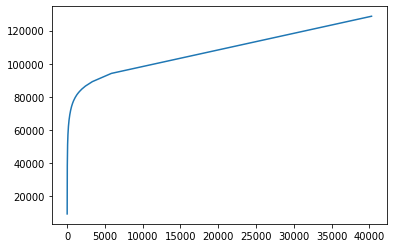

In [12]:
locations_to_geoloc["count"][lambda s: s > 0].cumsum().plot()

In [11]:
print("Users locations")
save_profiles_geoloc(locations_to_geoloc, fname=GEOLOCATION_PROFILES_FNAME, base_path=DATA_GEOLOC_PATH, limit=1, sleep=.1)

0it [00:00, ?it/s]

Users locations


387it [02:04,  3.10it/s]


# 3. Analysis geoloc data

In [14]:
gdf = read_geoloc(join(DATA_GEOLOC_PATH, GEOLOCATION_PROFILES_FNAME))

In [13]:
users_with_geoloc = pd.merge(
    left=users_df[["id_str", "location"]],
    right=gdf[~gdf.input_location.isin(weird_locations)].groupby("input_location").first().reset_index()[["input_location", "country", "osm_value", "name", "county", "state", "type"]],
    left_on="location", right_on="input_location", how='left'
).drop(columns="input_location")

users_with_geoloc.to_csv(
    join(DATA_GEOLOC_PATH, "users_profiles_with_geoloc.csv")
)

In [5]:
users_with_geoloc = pd.read_csv(join(DATA_GEOLOC_PATH, "users_profiles_with_geoloc.csv"))

In [6]:
users_per_country = users_with_geoloc.country.dropna().value_counts()

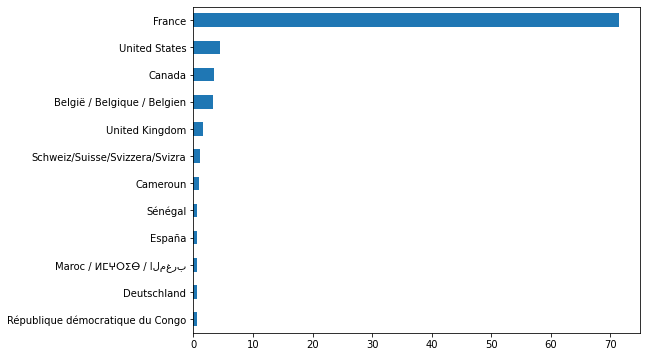

In [7]:
ax = (users_per_country/sum(users_per_country)*100).sort_values().iloc[-12:].plot.barh(figsize=(8, 6))
ax.figure.savefig(join(FIGS_PATH, "users_per_country.png"), bbox_inches="tight")

### Add counts

In [16]:
loc_count_dict = {row["location"]:row["count"] for _, row in locations_to_geoloc.drop_duplicates().iterrows()}
gdf["count"] = gdf.input_location.apply(lambda loc: loc_count_dict.get(loc))

### Plotting results

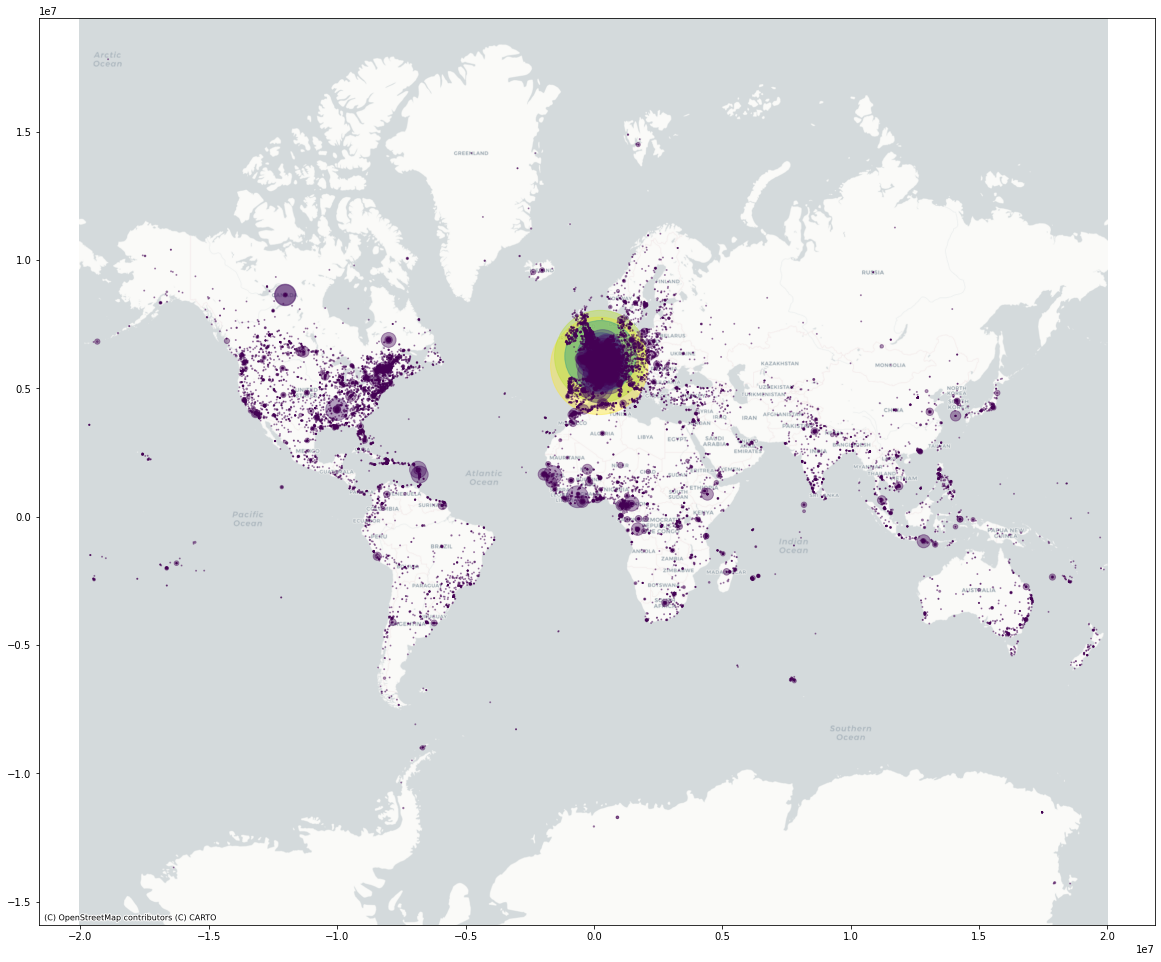

In [17]:
ax = gdf.to_crs(3857).plot(alpha=.40, figsize=(20, 20), column="count", markersize=gdf["count"])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) #ctx.providers.OpenStreetMap.Mapnik also good
ax.figure.savefig(join(FIGS_PATH, "carte_tw_lang_fr.png"), bbox_inches="tight")

# II) Geolocalisation - contactless

## 1. From user_id to profiles' location

Import data

In [32]:
df_contactless = pd.read_pickle(r"/home/cash/output/cleaned_queries/without_geoloc/query_fr_contactless_cleaned.pickle")

Create log

In [33]:
define_logger()

In [34]:
df_contactless.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'type_contactless', 'clean_tweet', 'pertinence_score',
       'french_score', 'english_score', 'datetime'],
      dtype='object')

In [35]:
df_contactless.shape

(48030, 42)

In [36]:
api = get_twitter_api()
list_users_id = df_contactless.user_id.dropna().astype(int).value_counts().index[slice(0, N_USERS)]
print(len(list_users_id))

24942


In [37]:
import time

print("Users profiles")

USER_PROFILES_CONTACTLESS_FNAME = 'users_profiles_contactless_fr.csv'

t1 = time.time()
save_user_profiles(api, list_users_id,
                   fname=USER_PROFILES_CONTACTLESS_FNAME, 
                   base_path=DATA_GEOLOC_PATH, 
                   print_every=250)
duration = time.time() - t1
print(duration)

0it [00:00, ?it/s]

Users profiles
/home/cash/data/geolocation/users_profiles_disparition_cash.csv
Beginning parsing
Add row for each user profile


8481it [2:17:40,  3.44it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

14579it [4:02:45,  2.44it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

19139it [5:18:42,  2.04it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit

## 2. From user location to coordinates

In [39]:
USER_PROFILES_CONTACTLESS_FNAME = 'users_profiles_contactless_fr.csv'
users_df = dt.fread(join(DATA_GEOLOC_PATH, USER_PROFILES_CONTACTLESS_FNAME)).to_pandas()

In [40]:

locations_to_geoloc = (
    users_df
    .location[lambda df: df != ""].value_counts()
    .reset_index().rename(columns={"index": "location", "location": "count"})
)

locations_to_geoloc.location = locations_to_geoloc.location.apply(clean_location)

weird_pronouns = "\Wil|\Welle|\where|\Whe|^they|\Wshe"
weird_locations = locations_to_geoloc[locations_to_geoloc.location.str.contains(weird_pronouns)][lambda df: df["count"] > 2].location.to_list()

In [41]:
locations_to_geoloc = (
    locations_to_geoloc
    .groupby("location")["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

<AxesSubplot:>

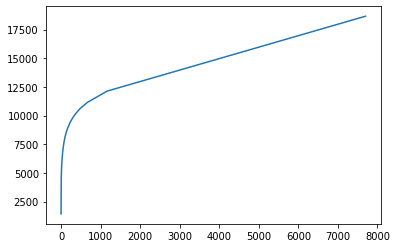

In [42]:
locations_to_geoloc["count"][lambda s: s > 0].cumsum().plot()

In [46]:
GEOLOCATION_PROFILES_CONTACLESS_FNAME = 'geolocation_users_contactless_fr.csv'
GEOLOCATION_PROFILES_CONTACLESS_FNAME

'geolocation_users_contactless_fr.csv'

In [45]:
print("Users locations")
save_profiles_geoloc(locations_to_geoloc, fname=GEOLOCATION_PROFILES_CONTACLESS_FNAME,
                     base_path=DATA_GEOLOC_PATH, limit=1, sleep=.1)

0it [00:00, ?it/s]

Users locations


7697it [46:42,  2.75it/s]


## 3. Analysis geoloc data

In [47]:
gdf = read_geoloc(join(DATA_GEOLOC_PATH, GEOLOCATION_PROFILES_CONTACLESS_FNAME))

In [48]:
users_with_geoloc = pd.merge(
    left=users_df[["id_str", "location"]],
    right=gdf[~gdf.input_location.isin(weird_locations)].groupby("input_location").first().reset_index()[["input_location", "country", "osm_value", "name", "county", "state", "type"]],
    left_on="location", right_on="input_location", how='left'
).drop(columns="input_location")

users_with_geoloc.to_csv(
    join(DATA_GEOLOC_PATH, "users_profiles_contacless_fr_with_geoloc.csv")
)

In [49]:
users_with_geoloc = pd.read_csv(join(DATA_GEOLOC_PATH, "users_profiles_contacless_fr_with_geoloc.csv"))

In [50]:
users_with_geoloc.shape

(24940, 9)

In [51]:
users_per_country = users_with_geoloc.country.dropna().value_counts()

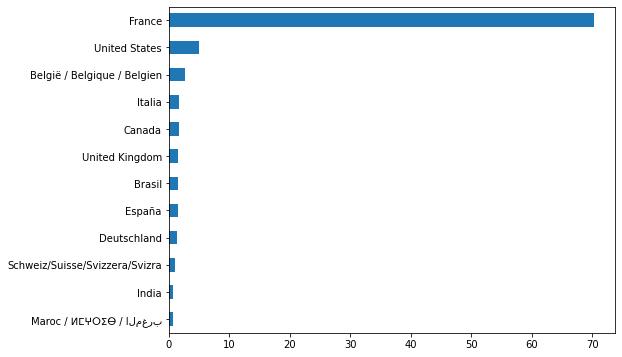

In [52]:
ax = (users_per_country/sum(users_per_country)*100).sort_values().iloc[-12:].plot.barh(figsize=(8, 6))
ax.figure.savefig(join(FIGS_PATH, "users_per_country_contactless.png"), bbox_inches="tight")

Add counts

In [53]:
loc_count_dict = {row["location"]:row["count"] for _, row in locations_to_geoloc.drop_duplicates().iterrows()}
gdf["count"] = gdf.input_location.apply(lambda loc: loc_count_dict.get(loc))

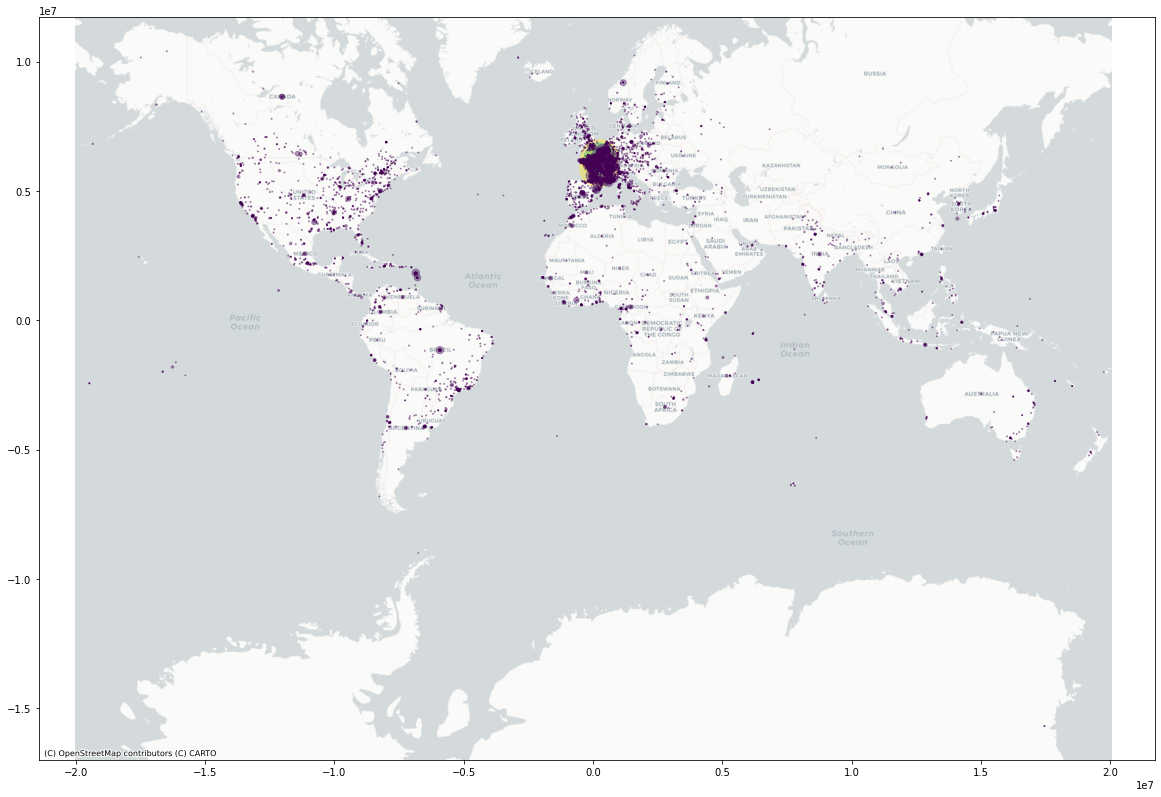

In [54]:
ax = gdf.to_crs(3857).plot(alpha=.40, figsize=(20, 20), column="count", markersize=gdf["count"])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) #ctx.providers.OpenStreetMap.Mapnik also good
ax.figure.savefig(join(FIGS_PATH, "carte_tw_lang_contactless_fr.png"), bbox_inches="tight")